# Hospitalizations as a function of traffic in NYC


In this project, I plan to explore the relationship between social distance and Covid-19 related hospitalizations in New York City during the last 4 months.
For this, I will try to quantify the amount of social distancing using tomtom's traffic index. Tomtom's traffic index is the percentage of extra time that it takes to travel any given day based on some baseline(no traffic). 

I will use this to create a daily traffic social distance (TSD) index that will reflect the change in congestion with respect to a normal traffic day. I will use the first week of February as my baseline traffic congestion. I will divide each day of the daily traffic index by the corresponding day in the base week. To smooth the data I will use a 7-day moving average.

This will give me an index where 0 indicates maximum TSD (no traffic), 1 indicates no TSD (same traffic as baseline). TSD greater than 1 indicate more traffic than usual.

Hospitalization data comes from [New York's City health webpage](https://www1.nyc.gov/site/doh/covid/covid-19-data.page). The dataset contains daily hospitalization numbers related to Covid_19 in NYC. To smooth the volatility of the hospitalization data I use a 7-day moving average. Then I find the day to day change to approximate the rate of hospital admissions.






## Importing libraries and files.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from datetime import date


In [2]:
h_df = pd.read_csv('../Data/hospitalizations.csv', index_col='DATE_OF_INTEREST', parse_dates=True)
t_df = pd.read_csv('../Data/NewYork_traffic.csv', index_col='Date', parse_dates= True)

# MTA data for sumbway and bus usage. 
#b_df = pd.read_csv('../Data/buses_ridership.csv', index_col='Date', parse_dates=True)
#s_df = pd.read_csv('../Data/Subway_ridership.csv', index_col='Date', parse_dates=True )

## Hospitalization Data

In [3]:
h_df.head(3)

,Cases,Hospitalizations,Deaths
DATE_OF_INTEREST,,,
2020-02-29,1,11,0
2020-03-01,1,4,0
2020-03-02,0,22,0


### Feature Engineering  

In [4]:
# trying a log transformatin of hospitalizations
h_df['log_hosp'] = np.log(h_df['Hospitalizations'])

In [5]:
h_df.tail(2)

,Cases,Hospitalizations,Deaths,log_hosp
DATE_OF_INTEREST,,,,
2020-06-24,186,30,15,3.401197
2020-06-25,143,27,7,3.295837


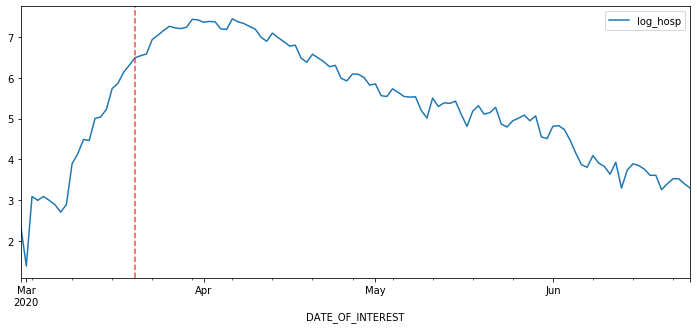

In [6]:
ax = h_df[['log_hosp']].plot(figsize=(12,5));
# Dashed line shows March 20th the date New York when officialy into PAUSE.
ax.axvline(x=date(2020, 3, 20), color='red', alpha=0.7,linestyle='dashed');

### Trying a rolling growth rate

In [7]:

h_df['hosp_rolling'] = h_df['Hospitalizations'].rolling(window=3).mean()
h_df['hosp_rolling_7'] = h_df['Hospitalizations'].rolling(window=7).mean()

h_df['log_hosp_rolling'] = h_df['log_hosp'].rolling(window=3).mean()
h_df['log_hosp_rolling_7'] = h_df['log_hosp'].rolling(window=7).mean()
#rates
h_df['hosp_rate'] = h_df['log_hosp_rolling']/h_df['log_hosp_rolling_7'] 
h_df['log_hosp_rate'] = np.log(h_df['hosp_rolling'])/np.log(h_df['hosp_rolling_7'])

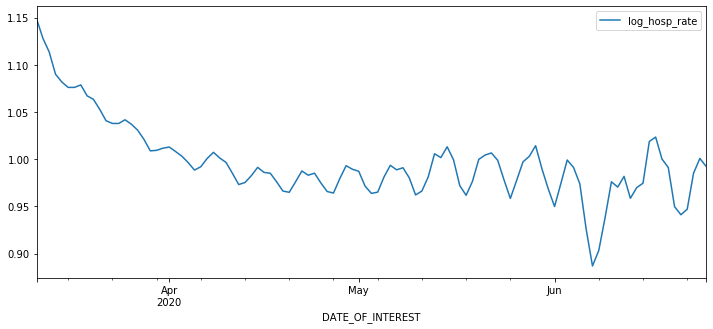

In [8]:
h_df[['log_hosp_rate']][11:].plot(figsize=(12,5));

### hosp_change
I create a hospitalization index by finding the daily percentage of change in the 7-day rolling hospitalization numbers.

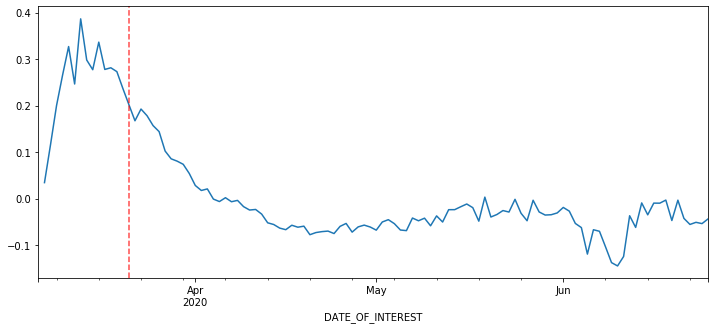

In [9]:
# Percentage change between the current and a prior element.
h_df['hosp_change'] =h_df[['hosp_rolling_7']].pct_change()

# plot of the change in daily change in hospitalizatios
ax = h_df['hosp_change'][6:].plot(figsize=(12,5));
ax.axvline(x=date(2020, 3, 21), color='red', alpha=0.7,linestyle='dashed');

In [10]:
h_df.head(5)

,Cases,Hospitalizations,Deaths,log_hosp,hosp_rolling,hosp_rolling_7,log_hosp_rolling,log_hosp_rolling_7,hosp_rate,log_hosp_rate,hosp_change
DATE_OF_INTEREST,,,,,,,,,,,
2020-02-29,1,11,0,2.397895,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,1,4,0,1.386294,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-02,0,22,0,3.091042,12.333333,NaN,2.291744,NaN,NaN,NaN,NaN
2020-03-03,2,20,0,2.995732,15.333333,NaN,2.491023,NaN,NaN,NaN,NaN
2020-03-04,5,22,0,3.091042,21.333333,NaN,3.059272,NaN,NaN,NaN,NaN


## Social distance - Traffic index

In [11]:
t_df.tail()

,trafic_index,first week of February
Date,,
2020-06-23,16,28
2020-06-24,16,28
2020-06-25,17,37
2020-06-26,19,34
2020-06-27,10,18


### Feature Engineering 

I use the first week of February as my baseline traffic congestion. I divide each day of the daily traffic index by the corresponding day in the base week.

In [12]:
t_df['TSD'] = t_df['trafic_index']/t_df['first week of February']

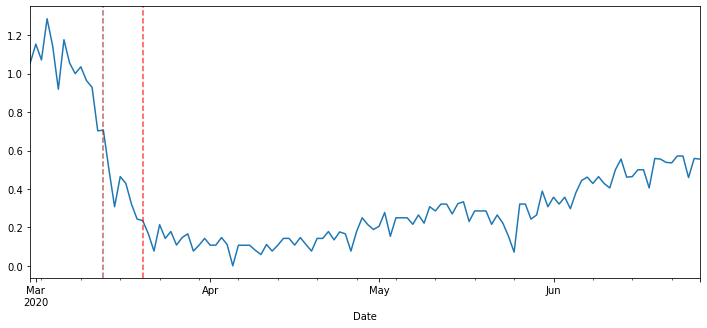

In [13]:
ax = t_df['TSD'].plot(figsize=(12,5));
ax.axvline(x=date(2020, 3, 13), color='brown', alpha=0.7,linestyle='dashed');
ax.axvline(x=date(2020, 3, 20), color='red', alpha=0.7,linestyle='dashed');

To smooth the data I use a 7-day moving average.

In [14]:
t_df['TSD_rolling'] = t_df['TSD'].rolling(window=7).mean()

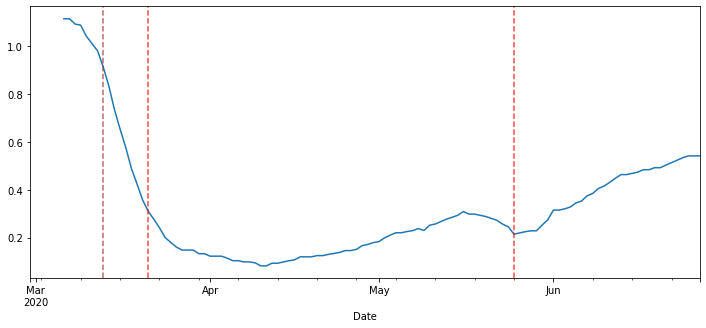

In [15]:
ax = t_df['TSD_rolling'].plot(figsize=(12,5));
ax.axvline(x=date(2020, 3, 21), color='red', alpha=0.7, linestyle='dashed');
ax.axvline(x=date(2020, 5, 25), color='red', alpha=0.7, linestyle='dashed');
ax.axvline(x=date(2020, 3, 13), color='brown', alpha=0.7,linestyle='dashed');

In [16]:
def diff_series(df, col, lag):
    """Function that lags the value of a colun given the dataframe the name of the 
    column by a number of lags"""
    for i in range(0,lag,1):
        new_col = col+f'_lag_{i+1}'
        df[new_col] = df[col].shift(i+1)
    

In [17]:
diff_series(t_df, 'TSD_rolling', 30)

In [18]:
t_df.head(15)

,trafic_index,first week of February,TSD,TSD_rolling,TSD_rolling_lag_1,TSD_rolling_lag_2,TSD_rolling_lag_3,TSD_rolling_lag_4,TSD_rolling_lag_5,TSD_rolling_lag_6,...,TSD_rolling_lag_21,TSD_rolling_lag_22,TSD_rolling_lag_23,TSD_rolling_lag_24,TSD_rolling_lag_25,TSD_rolling_lag_26,TSD_rolling_lag_27,TSD_rolling_lag_28,TSD_rolling_lag_29,TSD_rolling_lag_30
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-29,19,18,1.055556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,15,13,1.153846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-02,30,28,1.071429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-03,36,28,1.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-04,32,28,1.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-05,34,37,0.918919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-06,40,34,1.176471,1.114970,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-07,19,18,1.055556,1.114970,1.114970,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08,13,13,1.000000,1.092992,1.114970,1.114970,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# There are two extra dates for traffic data
h_df['hosp_change'].shape, t_df['TSD_rolling_lag_14'].shape

((118,), (120,))

## Linear  regression model

I fit a simple linear model using the traffic social distance `'TSD_rolling'` as a predictor of Hospitalization's percentage growth `'hosp_change'` and test the $R^{2}$ at differest lags.

In [20]:
def lag_finder(n):
    """Returns the rsquare(R^2) of each of the OLS model for TSD_rolling column lag up to
    n times"""
    rsquared =[]
    for i in range(1,n):
        # slice because the nan generated with creating the rolling mean
        # and because there are two extra days of TSD data t_df[6:-2] = h_df[6:]
        X = sm.add_constant(t_df[f'TSD_rolling_lag_{i}'][6+i:-2])
        model = sm.OLS(h_df['hosp_change'][6+i:],X)
        results = model.fit()
        rsquared.append(results.rsquared)
    return rsquared
        

/Users/flatironschool/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


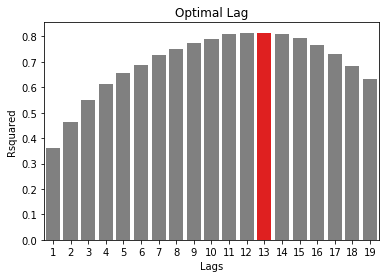

In [21]:
# fitting OLS regression on 20 lags
rsqr = lag_finder(20)
lag = list(range(1,20))

# Makes red the highest column
clrs = ['gray' if (x < max(rsqr)) else 'red' for x in rsqr ]
ax = sns.barplot(x=lag, y=rsqr, palette=clrs) 
plt.xlabel('Lags')
plt.ylabel('Rsquared')
plt.title("Optimal Lag");

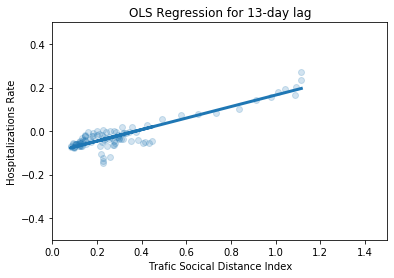

In [22]:
#Exploring optimal lag
X = sm.add_constant(t_df['TSD_rolling_lag_13'][19:-2])
model = sm.OLS(h_df['hosp_change'][19:],X)
results = model.fit()

plt.scatter(t_df['TSD_rolling_lag_13'][:-2],h_df['hosp_change'],alpha=0.2)
y_predict = results.params[0] + results.params[1]*t_df['TSD_rolling_lag_13'][:-2]
plt.plot(t_df['TSD_rolling_lag_13'][:-2],y_predict, linewidth=3)
plt.xlim(0,1.5)
plt.ylim(-0.5,0.5)
plt.xlabel('Trafic Socical Distance Index')
plt.ylabel('Hospitalizations Rate')
plt.title('OLS Regression for 13-day lag');

In [23]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            hosp_change   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     426.6
Date:                Tue, 30 Jun 2020   Prob (F-statistic):           2.74e-37
Time:                        12:47:25   Log-Likelihood:                 198.88
No. Observations:                  99   AIC:                            -393.8
Df Residuals:                      97   BIC:                            -388.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0989      0